# Data Preperation
In this notebook, I retrieve census tract level data from ACS as our baseline map. 

In [2]:
import numpy as np
import pandas as pd

In [3]:
# read in census api
import census

In [4]:
# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.display.float_format = '{:.2f}'.format  # Avoid scientific notation

# Set API Key
api_key = "64cf38e923af4727b9aafdd762ffa44d37aed7f5"
c = census.Census(api_key)

In [5]:
# Chicago-specific settings
city_name = 'Chicago'
state = '17'
FIPS = ['031', '043', '089', '093', '097', '111', '197']
sql_query = 'state:{} county:*'.format(state)

# Function to filter FIPS codes
def filter_FIPS(df):
    return df[df['county'].isin(FIPS)]


In [6]:
# Variables to fetch from ACS 2023
variables_2023 = ['B01003_001E', # total population
                  'B02001_002E', # white alone population
                    'B11001_001E', # total households
                    'B25077_001E', # median home value in 2023
                    'B25064_001E', # median gross rent in 2023
                    'B06011_001E', # Median income in the past 12 months (in 2023 inflation-adjusted dollars) for the population 15 years and over 
                    'GEO_ID'
                    ]

In [7]:
# Run API query
var_dict_acs5 = c.acs5.get(variables_2023, geo={'for': 'tract:*', 'in': sql_query}, year=2023)

In [8]:
# Convert to DataFrame and filter by FIPS
df_2023 = pd.DataFrame.from_dict(var_dict_acs5)
df_2023['FIPS'] = df_2023['state'] + df_2023['county'] + df_2023['tract']
df_2023 = filter_FIPS(df_2023)
df_2023.head(10)

,B01003_001E,B02001_002E,B11001_001E,B25077_001E,B25064_001E,B06011_001E,GEO_ID,state,county,tract,FIPS
150,3726.00,1475.00,2190.00,296600.00,1252.00,37386.00,1400000US17031010100,17,031,010100,17031010100
151,7588.00,1883.00,3038.00,239100.00,1333.00,39311.00,1400000US17031010201,17,031,010201,17031010201
152,2609.00,987.00,1130.00,231900.00,1292.00,34938.00,1400000US17031010202,17,031,010202,17031010202
153,6311.00,3558.00,3185.00,305000.00,1257.00,38532.00,1400000US17031010300,17,031,010300,17031010300
154,4282.00,3349.00,2058.00,229400.00,1248.00,33561.00,1400000US17031010400,17,031,010400,17031010400
155,3519.00,2298.00,2379.00,196600.00,1176.00,36258.00,1400000US17031010501,17,031,010501,17031010501
156,3329.00,2171.00,1637.00,282200.00,1311.00,36926.00,1400000US17031010502,17,031,010502,17031010502
157,2844.00,1806.00,1477.00,470500.00,1122.00,13289.00,1400000US17031010503,17,031,010503,17031010503
158,6708.00,3804.00,3066.00,254500.00,1276.00,38090.00,1400000US17031010600,17,031,010600,17031010600
159,3573.00,1431.00,1652.00,345400.00,1338.00,43372.00,1400000US17031010701,17,031,010701,17031010701


In [9]:
# Rename variables
# Rename columns
df_2023 = df_2023.rename(columns={  'B01003_001E': 'pop',
                                    'B02001_002E': 'white',
                                    'B11001_001E': 'hh',
                                    'B25077_001E': 'mhval',
                                    'B25064_001E': 'mrent',
                                    'B06011_001E':'indinc'
                                   })

In [10]:
df_2023.head(10)

,pop,white,hh,mhval,mrent,indinc,GEO_ID,state,county,tract,FIPS
150,3726.00,1475.00,2190.00,296600.00,1252.00,37386.00,1400000US17031010100,17,031,010100,17031010100
151,7588.00,1883.00,3038.00,239100.00,1333.00,39311.00,1400000US17031010201,17,031,010201,17031010201
152,2609.00,987.00,1130.00,231900.00,1292.00,34938.00,1400000US17031010202,17,031,010202,17031010202
153,6311.00,3558.00,3185.00,305000.00,1257.00,38532.00,1400000US17031010300,17,031,010300,17031010300
154,4282.00,3349.00,2058.00,229400.00,1248.00,33561.00,1400000US17031010400,17,031,010400,17031010400
155,3519.00,2298.00,2379.00,196600.00,1176.00,36258.00,1400000US17031010501,17,031,010501,17031010501
156,3329.00,2171.00,1637.00,282200.00,1311.00,36926.00,1400000US17031010502,17,031,010502,17031010502
157,2844.00,1806.00,1477.00,470500.00,1122.00,13289.00,1400000US17031010503,17,031,010503,17031010503
158,6708.00,3804.00,3066.00,254500.00,1276.00,38090.00,1400000US17031010600,17,031,010600,17031010600
159,3573.00,1431.00,1652.00,345400.00,1338.00,43372.00,1400000US17031010701,17,031,010701,17031010701


In [11]:
df_2023.shape

(2072, 11)

# Geographic Information

In this section, I incorporate data from 2023 Line/Shape files. 

In [12]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns

In [13]:
geofile_path_23 = 'data/tl_2023_17_tract.shp'

In [14]:
# Load census tract shapefile
tracts = gpd.read_file(geofile_path_23)
tracts = tracts.to_crs(epsg=3857)  # Web Mercator projection

# Merge data
tracts['GEOID'] = tracts['GEOID'].astype(str)
df_2023['FIPS'] = df_2023['FIPS'].astype(str)
df_tract = tracts.merge(df_2023, left_on='GEOID', right_on='FIPS', how='inner')

df_tract.head(10)

,STATEFP,COUNTYFP,TRACTCE,GEOID,GEOIDFQ,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,pop,white,hh,mhval,mrent,indinc,GEO_ID,state,county,tract,FIPS
0,17,111,871113,17111871113,1400000US17111871113,8711.13,Census Tract 8711.13,G5020,S,9639931,0,+42.2188156,-088.4082005,"POLYGON ((-9843154.521 5197094.15, -9843128.24...",3986.00,3062.00,1158.00,355000.00,-666666666.00,47729.00,1400000US17111871113,17,111,871113,17111871113
1,17,111,870105,17111870105,1400000US17111870105,8701.05,Census Tract 8701.05,G5020,S,27822811,228774,+42.4383703,-088.2279460,"POLYGON ((-9826924.603 5223935.351, -9826924.6...",3939.00,3179.00,1365.00,325400.00,1246.00,48468.00,1400000US17111870105,17,111,870105,17111870105
2,17,111,871501,17111871501,1400000US17111871501,8715.01,Census Tract 8715.01,G5020,S,54155922,72795,+42.1696821,-088.5216977,"POLYGON ((-9862755.714 5190059.841, -9862621.3...",6718.00,5768.00,3609.00,324000.00,-666666666.00,48730.00,1400000US17111871501,17,111,871501,17111871501
3,17,111,871115,17111871115,1400000US17111871115,8711.15,Census Tract 8711.15,G5020,S,3423380,17941,+42.1623196,-088.4165043,"POLYGON ((-9844258.587 5184051.095, -9844248.3...",3834.00,2707.00,1409.00,289100.00,-666666666.00,46477.00,1400000US17111871115,17,111,871115,17111871115
4,17,111,870404,17111870404,1400000US17111870404,8704.04,Census Tract 8704.04,G5020,S,36381789,725964,+42.3455834,-088.4050104,"POLYGON ((-9848691.679 5211289.228, -9848691.6...",3955.00,3467.00,1439.00,265200.00,1646.00,53206.00,1400000US17111870404,17,111,870404,17111870404
5,17,111,871112,17111871112,1400000US17111871112,8711.12,Census Tract 8711.12,G5020,S,10307808,329130,+42.2245142,-088.3866881,"POLYGON ((-9840556.65 5194251.158, -9840555.09...",5405.00,4693.00,1722.00,414300.00,896.00,50366.00,1400000US17111871112,17,111,871112,17111871112
6,17,111,870104,17111870104,1400000US17111870104,8701.04,Census Tract 8701.04,G5020,S,58345100,411441,+42.4581272,-088.2935363,"POLYGON ((-9834623.012 5223807.958, -9834622.2...",4878.00,4440.00,2139.00,316200.00,1183.00,45805.00,1400000US17111870104,17,111,870104,17111870104
7,17,111,870403,17111870403,1400000US17111870403,8704.03,Census Tract 8704.03,G5020,S,51286863,605142,+42.3842476,-088.4280819,"POLYGON ((-9848691.011 5216138.598, -9848689.5...",4299.00,3213.00,1478.00,264900.00,1310.00,52520.00,1400000US17111870403,17,111,870403,17111870403
8,17,111,871502,17111871502,1400000US17111871502,8715.02,Census Tract 8715.02,G5020,S,159063729,56810,+42.2514030,-088.5119396,"POLYGON ((-9861676.809 5199278.646, -9861676.6...",8799.00,6496.00,2925.00,355100.00,1775.00,61808.00,1400000US17111871502,17,111,871502,17111871502
9,17,111,870106,17111870106,1400000US17111870106,8701.06,Census Tract 8701.06,G5020,S,13687077,35030,+42.4645932,-088.2327517,"POLYGON ((-9823682.114 5233016.342, -9823679.1...",2735.00,2477.00,948.00,370200.00,-666666666.00,56275.00,1400000US17111870106,17,111,870106,17111870106


In [15]:
# drop unnecessary columns
df_tract_clean = df_tract.drop(columns=['STATEFP', 'COUNTYFP', 'GEO_ID', 'FIPS'])
df_tract_clean.head(10)

,TRACTCE,GEOID,GEOIDFQ,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,pop,white,hh,mhval,mrent,indinc,state,county,tract
0,871113,17111871113,1400000US17111871113,8711.13,Census Tract 8711.13,G5020,S,9639931,0,+42.2188156,-088.4082005,"POLYGON ((-9843154.521 5197094.15, -9843128.24...",3986.00,3062.00,1158.00,355000.00,-666666666.00,47729.00,17,111,871113
1,870105,17111870105,1400000US17111870105,8701.05,Census Tract 8701.05,G5020,S,27822811,228774,+42.4383703,-088.2279460,"POLYGON ((-9826924.603 5223935.351, -9826924.6...",3939.00,3179.00,1365.00,325400.00,1246.00,48468.00,17,111,870105
2,871501,17111871501,1400000US17111871501,8715.01,Census Tract 8715.01,G5020,S,54155922,72795,+42.1696821,-088.5216977,"POLYGON ((-9862755.714 5190059.841, -9862621.3...",6718.00,5768.00,3609.00,324000.00,-666666666.00,48730.00,17,111,871501
3,871115,17111871115,1400000US17111871115,8711.15,Census Tract 8711.15,G5020,S,3423380,17941,+42.1623196,-088.4165043,"POLYGON ((-9844258.587 5184051.095, -9844248.3...",3834.00,2707.00,1409.00,289100.00,-666666666.00,46477.00,17,111,871115
4,870404,17111870404,1400000US17111870404,8704.04,Census Tract 8704.04,G5020,S,36381789,725964,+42.3455834,-088.4050104,"POLYGON ((-9848691.679 5211289.228, -9848691.6...",3955.00,3467.00,1439.00,265200.00,1646.00,53206.00,17,111,870404
5,871112,17111871112,1400000US17111871112,8711.12,Census Tract 8711.12,G5020,S,10307808,329130,+42.2245142,-088.3866881,"POLYGON ((-9840556.65 5194251.158, -9840555.09...",5405.00,4693.00,1722.00,414300.00,896.00,50366.00,17,111,871112
6,870104,17111870104,1400000US17111870104,8701.04,Census Tract 8701.04,G5020,S,58345100,411441,+42.4581272,-088.2935363,"POLYGON ((-9834623.012 5223807.958, -9834622.2...",4878.00,4440.00,2139.00,316200.00,1183.00,45805.00,17,111,870104
7,870403,17111870403,1400000US17111870403,8704.03,Census Tract 8704.03,G5020,S,51286863,605142,+42.3842476,-088.4280819,"POLYGON ((-9848691.011 5216138.598, -9848689.5...",4299.00,3213.00,1478.00,264900.00,1310.00,52520.00,17,111,870403
8,871502,17111871502,1400000US17111871502,8715.02,Census Tract 8715.02,G5020,S,159063729,56810,+42.2514030,-088.5119396,"POLYGON ((-9861676.809 5199278.646, -9861676.6...",8799.00,6496.00,2925.00,355100.00,1775.00,61808.00,17,111,871502
9,870106,17111870106,1400000US17111870106,8701.06,Census Tract 8701.06,G5020,S,13687077,35030,+42.4645932,-088.2327517,"POLYGON ((-9823682.114 5233016.342, -9823679.1...",2735.00,2477.00,948.00,370200.00,-666666666.00,56275.00,17,111,870106


# Match School Districts With Tracts

In [16]:
hs_23 = pd.read_csv("data/CPS-HS-2223.csv")

hs_23.head(5)

,the_geom,SCHOOL_ID,SCHOOL_ADD,GRADE_CAT,BOUNDARYGR,SCHOOL_NAM
0,MULTIPOLYGON (((-87.72651800685355 41.91545041...,609691,"4338 W WABANSIA AVE CHICAGO, IL 60639",HS,"9, 10, 11, 12",NORTH-GRAND HS
1,MULTIPOLYGON (((-87.70108291641304 41.96852098...,609695,"5110 N DAMEN AVE CHICAGO, IL 60625",HS,"9, 10, 11, 12",AMUNDSEN HS
2,MULTIPOLYGON (((-87.70248587280773 41.75904716...,609698,"3939 W 79TH ST CHICAGO, IL 60652",HS,"9, 10, 11, 12",BOGAN HS
3,MULTIPOLYGON (((-87.6247685008912 41.743648544...,610323,"2710 E 89TH ST CHICAGO, IL 60617",HS,"9, 10, 11, 12",BOWEN HS
4,MULTIPOLYGON (((-87.76565644924996 41.90230183...,610518,"231 N PINE AVE CHICAGO, IL 60644",HS,"9, 10, 11, 12",AUSTIN CCA HS


In [17]:
from shapely import wkt
hs_23['geometry'] = hs_23['the_geom'].apply(wkt.loads)
schools_gdf = gpd.GeoDataFrame(hs_23, geometry='geometry', crs="EPSG:4326")
schools_gdf = schools_gdf.to_crs(epsg=3857)  # Convert to Web Mercator projection

schools_gdf.head(5)


,the_geom,SCHOOL_ID,SCHOOL_ADD,GRADE_CAT,BOUNDARYGR,SCHOOL_NAM,geometry
0,MULTIPOLYGON (((-87.72651800685355 41.91545041...,609691,"4338 W WABANSIA AVE CHICAGO, IL 60639",HS,"9, 10, 11, 12",NORTH-GRAND HS,"MULTIPOLYGON (((-9765671.314 5148322.728, -976..."
1,MULTIPOLYGON (((-87.70108291641304 41.96852098...,609695,"5110 N DAMEN AVE CHICAGO, IL 60625",HS,"9, 10, 11, 12",AMUNDSEN HS,"MULTIPOLYGON (((-9762839.892 5156265.207, -976..."
2,MULTIPOLYGON (((-87.70248587280773 41.75904716...,609698,"3939 W 79TH ST CHICAGO, IL 60652",HS,"9, 10, 11, 12",BOGAN HS,"MULTIPOLYGON (((-9762996.069 5124953.936, -976..."
3,MULTIPOLYGON (((-87.6247685008912 41.743648544...,610323,"2710 E 89TH ST CHICAGO, IL 60617",HS,"9, 10, 11, 12",BOWEN HS,"MULTIPOLYGON (((-9754344.61 5122656.254, -9754..."
4,MULTIPOLYGON (((-87.76565644924996 41.90230183...,610518,"231 N PINE AVE CHICAGO, IL 60644",HS,"9, 10, 11, 12",AUSTIN CCA HS,"MULTIPOLYGON (((-9770028.185 5146355.949, -977..."


In [18]:
matched_gdf = gpd.sjoin(df_tract_clean, schools_gdf, how="left", predicate='intersects')
matched_gdf.head(10)

,TRACTCE,GEOID,GEOIDFQ,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,pop,white,hh,mhval,mrent,indinc,state,county,tract,index_right,the_geom,SCHOOL_ID,SCHOOL_ADD,GRADE_CAT,BOUNDARYGR,SCHOOL_NAM
0,871113,17111871113,1400000US17111871113,8711.13,Census Tract 8711.13,G5020,S,9639931,0,+42.2188156,-088.4082005,"POLYGON ((-9843154.521 5197094.15, -9843128.24...",3986.00,3062.00,1158.00,355000.00,-666666666.00,47729.00,17,111,871113,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,870105,17111870105,1400000US17111870105,8701.05,Census Tract 8701.05,G5020,S,27822811,228774,+42.4383703,-088.2279460,"POLYGON ((-9826924.603 5223935.351, -9826924.6...",3939.00,3179.00,1365.00,325400.00,1246.00,48468.00,17,111,870105,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,871501,17111871501,1400000US17111871501,8715.01,Census Tract 8715.01,G5020,S,54155922,72795,+42.1696821,-088.5216977,"POLYGON ((-9862755.714 5190059.841, -9862621.3...",6718.00,5768.00,3609.00,324000.00,-666666666.00,48730.00,17,111,871501,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,871115,17111871115,1400000US17111871115,8711.15,Census Tract 8711.15,G5020,S,3423380,17941,+42.1623196,-088.4165043,"POLYGON ((-9844258.587 5184051.095, -9844248.3...",3834.00,2707.00,1409.00,289100.00,-666666666.00,46477.00,17,111,871115,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,870404,17111870404,1400000US17111870404,8704.04,Census Tract 8704.04,G5020,S,36381789,725964,+42.3455834,-088.4050104,"POLYGON ((-9848691.679 5211289.228, -9848691.6...",3955.00,3467.00,1439.00,265200.00,1646.00,53206.00,17,111,870404,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,871112,17111871112,1400000US17111871112,8711.12,Census Tract 8711.12,G5020,S,10307808,329130,+42.2245142,-088.3866881,"POLYGON ((-9840556.65 5194251.158, -9840555.09...",5405.00,4693.00,1722.00,414300.00,896.00,50366.00,17,111,871112,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,870104,17111870104,1400000US17111870104,8701.04,Census Tract 8701.04,G5020,S,58345100,411441,+42.4581272,-088.2935363,"POLYGON ((-9834623.012 5223807.958, -9834622.2...",4878.00,4440.00,2139.00,316200.00,1183.00,45805.00,17,111,870104,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,870403,17111870403,1400000US17111870403,8704.03,Census Tract 8704.03,G5020,S,51286863,605142,+42.3842476,-088.4280819,"POLYGON ((-9848691.011 5216138.598, -9848689.5...",4299.00,3213.00,1478.00,264900.00,1310.00,52520.00,17,111,870403,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,871502,17111871502,1400000US17111871502,8715.02,Census Tract 8715.02,G5020,S,159063729,56810,+42.2514030,-088.5119396,"POLYGON ((-9861676.809 5199278.646, -9861676.6...",8799.00,6496.00,2925.00,355100.00,1775.00,61808.00,17,111,871502,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,870106,17111870106,1400000US17111870106,8701.06,Census Tract 8701.06,G5020,S,13687077,35030,+42.4645932,-088.2327517,"POLYGON ((-9823682.114 5233016.342, -9823679.1...",2735.00,2477.00,948.00,370200.00,-666666666.00,56275.00,17,111,870106,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
matched_gdf['area_sq_m'] = matched_gdf.geometry.area
largest_tracts = matched_gdf.sort_values('area_sq_m', ascending=False)
print(largest_tracts.head())

     TRACTCE        GEOID               GEOIDFQ     NAME  \
1969  990000  17097990000  1400000US17097990000     9900   
919   990000  17031990000  1400000US17031990000     9900   
919   990000  17031990000  1400000US17031990000     9900   
1549  852403  17089852403  1400000US17089852403  8524.03   
90    870200  17111870200  1400000US17111870200     8702   

                  NAMELSAD  MTFCC FUNCSTAT      ALAND      AWATER  \
1969     Census Tract 9900  G5020        S          0  2298779958   
919      Census Tract 9900  G5020        S          0  1717072182   
919      Census Tract 9900  G5020        S          0  1717072182   
1549  Census Tract 8524.03  G5020        S  282008453      147970   
90       Census Tract 8702  G5020        S  271638100      521665   

         INTPTLAT      INTPTLON  \
1969  +42.3267427  -087.4318497   
919   +41.9739391  -087.4002947   
919   +41.9739391  -087.4002947   
1549  +41.8533585  -088.5371224   
90    +42.3928665  -088.5674929   

             

In [20]:
# Some areas have large water areas, we drop them
partition = matched_gdf[matched_gdf['AWATER'] < 1000000000]  
largest_tracts = partition.sort_values('AWATER', ascending=False)
print(largest_tracts.head())

     TRACTCE        GEOID               GEOIDFQ     NAME  \
2018  883402  17197883402  1400000US17197883402  8834.02   
1989  860808  17097860808  1400000US17097860808  8608.08   
1945  860903  17097860903  1400000US17097860903  8609.03   
2021  883306  17197883306  1400000US17197883306  8833.06   
2003  860807  17097860807  1400000US17097860807  8608.07   

                  NAMELSAD  MTFCC FUNCSTAT     ALAND   AWATER     INTPTLAT  \
2018  Census Tract 8834.02  G5020        S  60214924  6989906  +41.3370292   
1989  Census Tract 8608.08  G5020        S   9832055  6957073  +42.4528528   
1945  Census Tract 8609.03  G5020        S   6018094  6473016  +42.3915562   
2021  Census Tract 8833.06  G5020        S  65006830  5414806  +41.4134737   
2003  Census Tract 8608.07  G5020        S  16410765  4733519  +42.4533900   

          INTPTLON                                           geometry     pop  \
2018  -088.2018401  POLYGON ((-9823854.269 5067914.83, -9823687.84... 1983.00   
1989  -0

In [21]:
# drop unnecessary columns
partition = partition.drop(columns=['NAME', 'GEOIDFQ', 'the_geom', 'TRACTCE', 'FUNCSTAT', 'MTFCC', 'NAMELSAD'])
partition.head(10)

,GEOID,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,pop,white,hh,mhval,mrent,indinc,state,county,tract,index_right,SCHOOL_ID,SCHOOL_ADD,GRADE_CAT,BOUNDARYGR,SCHOOL_NAM,area_sq_m
0,17111871113,9639931,0,+42.2188156,-088.4082005,"POLYGON ((-9843154.521 5197094.15, -9843128.24...",3986.00,3062.00,1158.00,355000.00,-666666666.00,47729.00,17,111,871113,NaN,NaN,NaN,NaN,NaN,NaN,17587950.25
1,17111870105,27822811,228774,+42.4383703,-088.2279460,"POLYGON ((-9826924.603 5223935.351, -9826924.6...",3939.00,3179.00,1365.00,325400.00,1246.00,48468.00,17,111,870105,NaN,NaN,NaN,NaN,NaN,NaN,51539714.74
2,17111871501,54155922,72795,+42.1696821,-088.5216977,"POLYGON ((-9862755.714 5190059.841, -9862621.3...",6718.00,5768.00,3609.00,324000.00,-666666666.00,48730.00,17,111,871501,NaN,NaN,NaN,NaN,NaN,NaN,98802025.92
3,17111871115,3423380,17941,+42.1623196,-088.4165043,"POLYGON ((-9844258.587 5184051.095, -9844248.3...",3834.00,2707.00,1409.00,289100.00,-666666666.00,46477.00,17,111,871115,NaN,NaN,NaN,NaN,NaN,NaN,6266977.92
4,17111870404,36381789,725964,+42.3455834,-088.4050104,"POLYGON ((-9848691.679 5211289.228, -9848691.6...",3955.00,3467.00,1439.00,265200.00,1646.00,53206.00,17,111,870404,NaN,NaN,NaN,NaN,NaN,NaN,67981804.77
5,17111871112,10307808,329130,+42.2245142,-088.3866881,"POLYGON ((-9840556.65 5194251.158, -9840555.09...",5405.00,4693.00,1722.00,414300.00,896.00,50366.00,17,111,871112,NaN,NaN,NaN,NaN,NaN,NaN,19408786.12
6,17111870104,58345100,411441,+42.4581272,-088.2935363,"POLYGON ((-9834623.012 5223807.958, -9834622.2...",4878.00,4440.00,2139.00,316200.00,1183.00,45805.00,17,111,870104,NaN,NaN,NaN,NaN,NaN,NaN,108013610.23
7,17111870403,51286863,605142,+42.3842476,-088.4280819,"POLYGON ((-9848691.011 5216138.598, -9848689.5...",4299.00,3213.00,1478.00,264900.00,1310.00,52520.00,17,111,870403,NaN,NaN,NaN,NaN,NaN,NaN,95186061.30
8,17111871502,159063729,56810,+42.2514030,-088.5119396,"POLYGON ((-9861676.809 5199278.646, -9861676.6...",8799.00,6496.00,2925.00,355100.00,1775.00,61808.00,17,111,871502,NaN,NaN,NaN,NaN,NaN,NaN,290626110.82
9,17111870106,13687077,35030,+42.4645932,-088.2327517,"POLYGON ((-9823682.114 5233016.342, -9823679.1...",2735.00,2477.00,948.00,370200.00,-666666666.00,56275.00,17,111,870106,NaN,NaN,NaN,NaN,NaN,NaN,25233042.54


In [22]:
partition.dropna(subset=['SCHOOL_ID'], inplace=True)  # Drop rows with non-matching schools

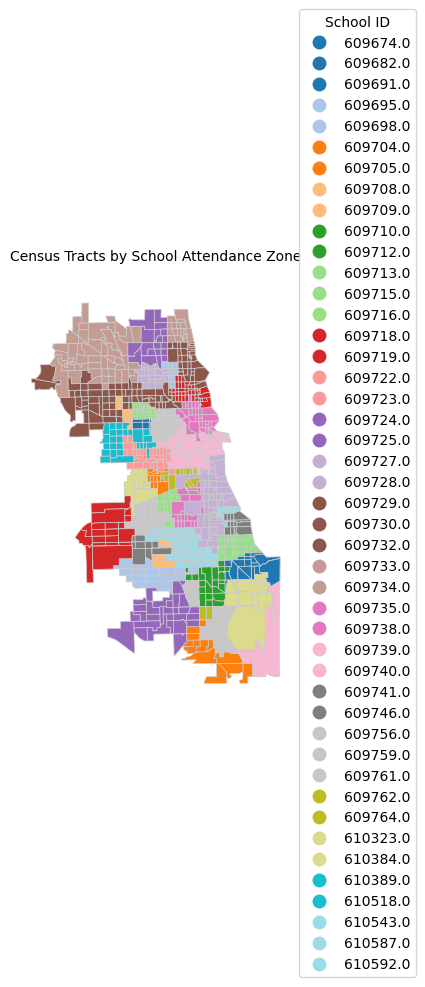

In [23]:
partition["SCHOOL_ID"] = partition["SCHOOL_ID"].astype('category')
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

partition.plot(
    column="SCHOOL_ID",
    categorical=True,
    legend=True,
    cmap='tab20', # Choose a colormap (e.g., 'tab20', 'viridis', 'Paired')
    linewidth=0.5,
    edgecolor='0.8', # Light grey edges for tracts
    ax=ax,
    legend_kwds={'title': "School ID", 'loc': 'center left', 'bbox_to_anchor': (1, 0.5)} # Adjust legend position
)

# --- 4. Customize and Show the Plot ---
# Remove the axis ticks and labels for a cleaner map
ax.set_axis_off()

# Add a title
ax.set_title('Census Tracts by School Attendance Zone', fontsize=10)

# Adjust layout to prevent the legend from being cut off
plt.tight_layout()

# Display the map
plt.show()

We see that all cencus tracts are matched with school districts. We export this data to a CSV file for further analysis.



In [24]:
partition = partition[partition['indinc'] > 0 & partition['indinc'].notnull()]
partition = partition[partition['pop'] > 0 & partition['pop'].notnull()]

In [25]:
partition.to_csv('data/partition_0.csv', index=False)